# Analysis of Reddit Comment Sentiments

###### Authors: Cameron Mandley, Jasmine Wu

### Provide your credentials to the runtime

In [454]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Use Classic DataFrame Display

In [455]:
%unload_ext google.colab.data_table

The google.colab.data_table extension is not loaded.


### Declare the Cloud project ID which will be used throughout this notebook

In [456]:
project_id = 'mindful-marking-297202'

### Sample approximately 2000 random rows

In [457]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sample_count = 2000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `fh-bigquery.reddit_comments.2010`''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `fh-bigquery.reddit_comments.2010`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)

Full dataset has 48489057 rows


### Remove Deleted Comments

In [458]:
df = df[df['body'] != '[deleted]']

In [459]:
from textblob import TextBlob
import pandas as pd
import numpy as np
from numpy import random
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
get_ipython().run_line_magic('matplotlib', 'inline')
from nltk import word_tokenize, download
import string
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Remove Stopwords

In [460]:
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')

comments = df['body']
comments_processed = []
for sentence in tqdm(comments):
    comments_processed.append(' '.join(token.lower() for token in nltk.word_tokenize(sentence) if token.lower() not in stopwords.words('english')))

  1%|          | 14/1805 [00:00<00:12, 139.87it/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 1805/1805 [00:08<00:00, 206.73it/s]


### Format Comments

In [462]:
from collections import Counter 
  
# split() returns list of all the words in the string 
total_comments = [0] * len(comments_processed)
i = 0
for comment in comments_processed:
  split_comment = comment.split()
  total_comments[i] = split_comment
  i = i+1

In [464]:
punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~`'''
# Removing punctuations in string 
# Using loop + punctuation string 
for i in range(len(total_comments)):
  for j in range(len(total_comments[i])):
    for ele in total_comments[i][j]: 
      if ele in punc:  
        total_comments[i][j] = 'None'
  total_comments[i] = np.array(total_comments[i])[np.array(total_comments[i]) != 'None']

In [465]:
string_comments = [str(comment).replace('[', '').replace(']', '').replace('\'', '') for comment in total_comments]

### Determine Comment Polarities

In [466]:
def detect_polarity(text):
  return TextBlob(text).sentiment.polarity

In [467]:
polarity = [detect_polarity(comment) for comment in string_comments]

In [469]:
comments_processed_df = pd.DataFrame({'body': comments_processed, 'polarity': polarity, 'subreddit_id': df['subreddit_id'], 'clean_comments': string_comments})

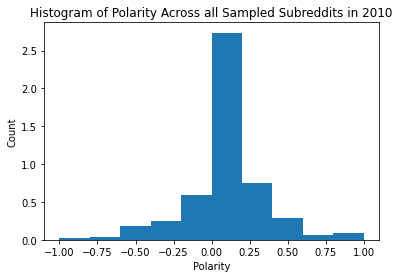

In [515]:
plt.hist(comments_processed_df['polarity'], density = True)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity Across all Sampled Subreddits in 2010');

In [472]:
import seaborn as sns

In [510]:
aggregated = comments_processed_df.groupby('subreddit_id').agg(np.mean).sample(20)

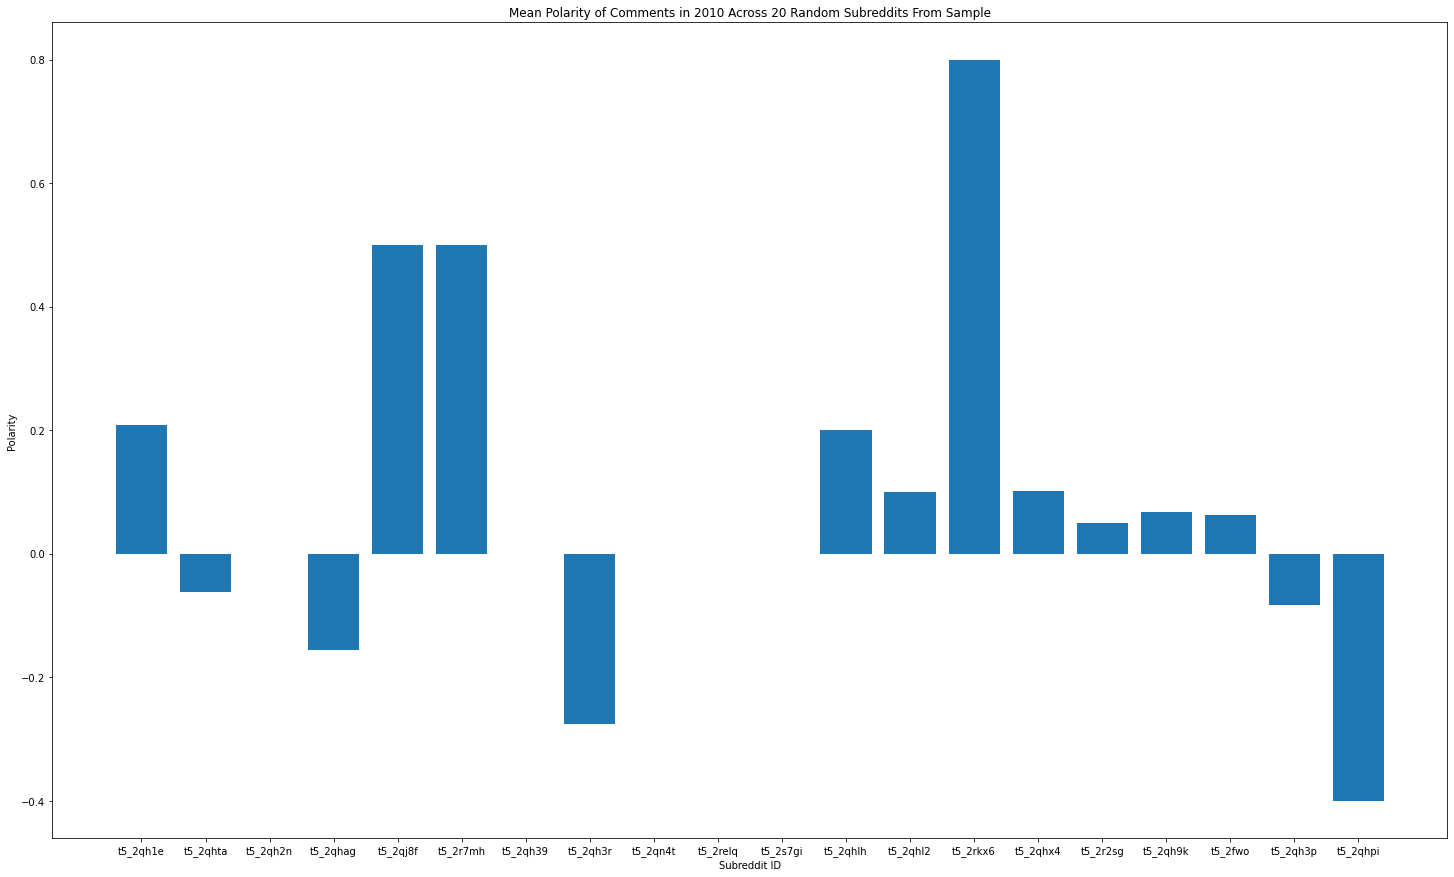

In [514]:
plt.figure(figsize=(25,15))
plt.bar(x=aggregated.index, height = aggregated['polarity'])
plt.xlabel('Subreddit ID')
plt.ylabel('Polarity')
plt.title('Mean Polarity of Comments in 2010 Across 20 Random Subreddits From Sample');
plt.show();

### Analyze Word Frequencies

In [474]:
from collections import Counter 
  
# split() returns list of all the words in the string 
split_comments = np.array([])
for i in comments_processed:
  split_comments = np.append(split_comments, i.split())

In [476]:
punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~`'''
# Removing punctuations in string 
# Using loop + punctuation string 
for i in range(len(split_comments)):
  for ele in split_comments[i]:  
    if ele in punc:  
        split_comments[i] = None

In [477]:
split_comments = split_comments[split_comments != 'None']

In [479]:
from collections import Counter
# Pass the split_it list to instance of Counter class. 
Counter = Counter(split_comments) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(51) 
  
print(most_occur)

[('like', 269), ('would', 225), ('one', 208), ('get', 181), ('http', 180), ('people', 177), ('think', 166), ('know', 133), ('time', 123), ('good', 120), ('also', 110), ('really', 109), ('gt', 104), ('much', 101), ('could', 94), ('well', 94), ('see', 91), ('make', 91), ('even', 90), ('going', 86), ('still', 82), ('right', 81), ('take', 76), ('way', 75), ('want', 74), ('never', 73), ('go', 71), ('something', 70), ('got', 70), ('use', 69), ('need', 68), ('though', 66), ('say', 66), ('work', 65), ('someone', 60), ('thing', 60), ('probably', 59), ('actually', 58), ('amp', 58), ('back', 57), ('said', 55), ('things', 55), ('pretty', 55), ('new', 54), ('find', 53), ('ca', 53), ('look', 52), ('may', 52), ('years', 52), ('made', 51), ('anything', 51)]


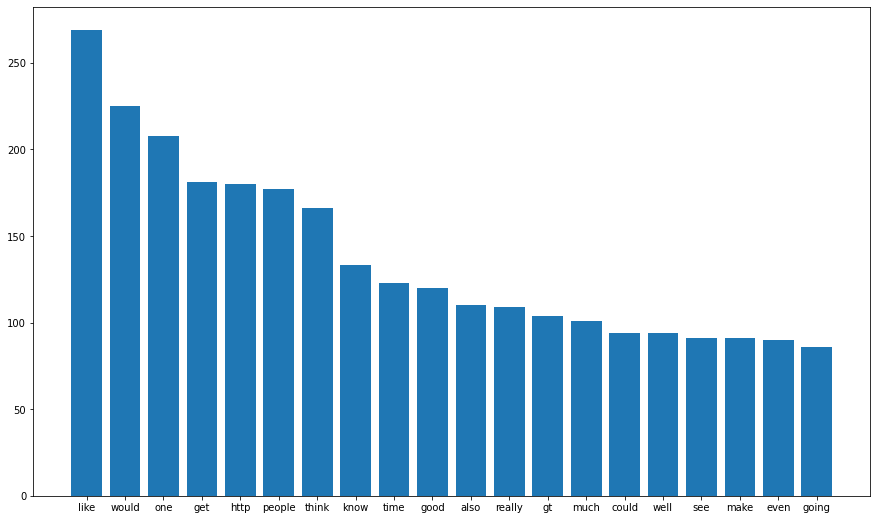

In [516]:
def return_words(words_and_occurances):
    words = np.array([tup[0] for tup in words_and_occurances])
    return words


# In[6]:


def return_occurances(words_and_occurances):
    occurances = np.array([tup[1] for tup in words_and_occurances])
    return occurances


# In[7]:


"""
Plot 20 words and their counts for comparison
"""
words = return_words(most_occur)
occurances = return_occurances(most_occur)
plt.figure(figsize=(15,9))
plt.bar(x = words[0:20], height = occurances[0:20]);
